# Lab 02: Segmentation

In this laboratory work you will create pipeline for cancer cells segmentation starting from reading data to preprocessing, creating training setup, experimenting with models.

## Part 1: Reading dataset

Write Dataset class inheriting regular `torch` dataset.

In this task we use small datset just to make this homework accessible for everyone, so please **do not** read all the data in constructor because it is not how it works for real life datasets. You need to read image from disk only when it is requesed (getitem).

Split data (persistently between runs) to train, val and test sets. Add corresponding parameter to dataset constructor.

In [1]:
!curl -JLO 'https://www.dropbox.com/scl/fi/gs3kzp6b8k6faf667m5tt/breast-cancer-cells-segmentation.zip?rlkey=md3mzikpwrvnaluxnhms7r4zn'
!unzip breast-cancer-cells-segmentation.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    329      0 --:--:-- --:--:-- --:--:--   329
100   491    0   491    0     0    349      0 --:--:--  0:00:01 --:--:--     0
100 93.6M  100 93.6M    0     0  32.1M      0  0:00:02  0:00:02 --:--:-- 90.9M
Archive:  breast-cancer-cells-segmentation.zip
  inflating: Images/ytma10_010704_benign1_ccd.tif  
  inflating: Images/ytma10_010704_benign1_ccd.tif.xml  
  inflating: Images/ytma10_010704_benign2_ccd.tif  
  inflating: Images/ytma10_010704_benign2_ccd.tif.xml  
  inflating: Images/ytma10_010704_benign3_ccd.tif  
  inflating: Images/ytma10_010704_benign3_ccd.tif.xml  
  inflating: Images/ytma10_010704_malignant1_ccd.tif  
  inflating: Images/ytma10_010704_malignant1_ccd.tif.xml  
  inflating: Images/ytma10_010704_malignant2_ccd.tif  
  inflating: Images/ytma10_010704_malignant2_ccd.tif.xml  
  infl

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import os
from pathlib import Path

Images_dir = "Images"
Masks_dir = "Masks"

Images = np.sort([img for img in Path(Images_dir).glob("*.tif")])
Masks = np.sort([mask for mask in Path(Masks_dir).glob("*.TIF")])

train_images, test_images, train_masks, test_masks = train_test_split(Images, Masks, test_size=0.15)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.15)

In [3]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, images, masks):
      self.images = images
      self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        image = Image.open(image_path)
        mask = Image.open(mask_path)

        return image, mask

train_dataset = CustomDataset(train_images, train_masks)
val_dataset = CustomDataset(val_images, val_masks)
test_dataset = CustomDataset(test_images, test_masks)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

## Part 1.1: Analyzing dataset

Each time you build model you first should make EDA to understand your data.

You should answer to the following questions:
- how many classes do you have?
- what is class balance?
- how many cells (roughly) do you have in train data?

Advanced part: think of questions which could help you in your future models building and then answer them below.

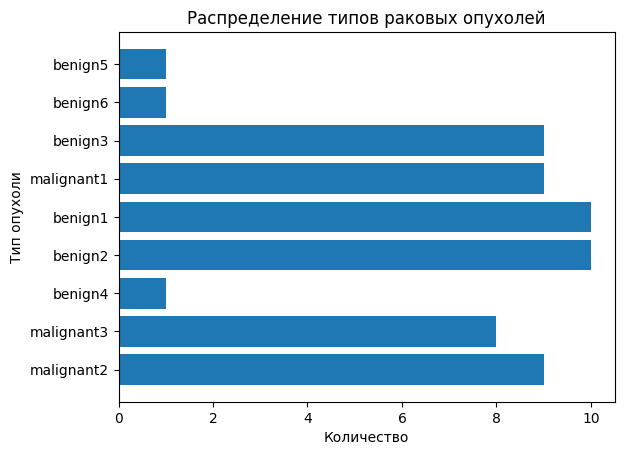

Количество классов опухоли 10
Количество данных в тренировочном датасете 41
Количество данных в валидационном датасете 8
Количество данных в тестовом датасете 9


In [4]:
import os
import matplotlib.pyplot as plt

tumor_types = {}

for filename in os.listdir("Masks"):
    if filename.endswith(".TIF"):
        tumor_type = filename.split("_")[2]
        tumor_type = tumor_type[:-4]
        tumor_types[tumor_type] = tumor_types.get(tumor_type, 0) + 1


labels = tumor_types.keys()
counts = tumor_types.values()


plt.barh(list(labels), list(counts))
plt.xlabel('Количество')
plt.ylabel('Тип опухоли')
plt.title('Распределение типов раковых опухолей')
plt.show()

print(f'Количество классов опухоли {10}')
print(f'Количество данных в тренировочном датасете {len(train_dataset)}')
print(f'Количество данных в валидационном датасете {len(val_dataset)}')
print(f'Количество данных в тестовом датасете {len(test_dataset)}')

Нужно преобразовать данные в верный формат для подачи в UNET

In [5]:
from torchvision import transforms

def collate_fn(batch):
  images, masks = zip(*batch)


  preprocess_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
  ])

  preprocess_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
  ])

  images = torch.stack([preprocess_image(image) for image in images])
  masks = torch.stack([preprocess_mask(mask) for mask in masks])

  return images, masks

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn, shuffle=False)

In [18]:
def plot_images(images, masks):
    fig, ax = plt.subplots(1, 8, figsize=(20, 30))
    for i, (img, mask) in enumerate(zip(images, masks)):
        ax[i].imshow(img.permute(1, 2, 0))
        ax[i].imshow(mask.permute(1, 2, 0), alpha=0.5)

    plt.show()

batch = next(iter(train_dataloader))
inputs, ground_truth = batch[0][:8], batch[1][:8]
plot_images(inputs, ground_truth)

## Part 2: Unet model

Implement class of Unet model according with [the original paper](https://arxiv.org/pdf/1505.04597).
Ajust size of the network according with your input data.

In [8]:
from torchvision.transforms import CenterCrop
from torch import nn
from torch import optim

def conv_layer(chann_in, chann_out, kernel_size=3, padding_size=1):
    layer = nn.Sequential(
        nn.Conv2d(chann_in, chann_out, kernel_size=kernel_size, padding=padding_size),
        nn.BatchNorm2d(chann_out),
        nn.ReLU(inplace=True)
    )
    return layer

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            conv_layer(3, 64),
            conv_layer(64, 64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = nn.Sequential(
            conv_layer(64, 128),
            conv_layer(128, 128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(
            conv_layer(128, 256),
            conv_layer(256, 256)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(
            conv_layer(256, 512),
            conv_layer(512, 512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck_conv = nn.Sequential(
            conv_layer(512, 1024),
            conv_layer(1024, 1024)
        )

        self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            conv_layer(1024, 512),
            conv_layer(512, 512)
        )
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            conv_layer(512, 256),
            conv_layer(256, 256)
        )
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            conv_layer(256, 128),
            conv_layer(128, 128)
        )
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            conv_layer(128, 64),
            conv_layer(64, 64),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        conv0 = self.enc_conv0(x)
        x = self.pool0(conv0)

        conv1 = self.enc_conv1(x)
        x = self.pool1(conv1)

        conv2 = self.enc_conv2(x)
        x = self.pool2(conv2)

        conv3 = self.enc_conv3(x)
        x = self.pool3(conv3)

        x = self.bottleneck_conv(x)

        x = self.upsample0(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dec_conv0(x)

        x = self.upsample1(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dec_conv1(x)

        x = self.upsample2(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dec_conv2(x)

        x = self.upsample3(x)
        x = torch.cat([x, conv0], dim=1)
        x = self.dec_conv3(x)

        return x

## Part 3: Unet training with different losses

Train model in three setups:
- Crossentropy loss
- Dice loss
- Composition of CE and Dice

Advanced:\
For training procedure use one of frameworks for models training - Lightning, Hugging Face, Catalyst, Ignite.\
_Hint: this will make your life easier!_

Save all three trained models to disk!

Use validation set to evaluate models.

In [9]:
import torch.nn.functional as F

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):


        inputs = F.sigmoid(inputs)


        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):


        inputs = F.sigmoid(inputs)


        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [12]:
class BCELoss(nn.Module):
    def __init__(self):
        super(BCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):


        inputs = F.sigmoid(inputs)


        inputs = inputs.view(-1)
        targets = targets.view(-1)

        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')

        return BCE

In [13]:
!pip install lightning

In [14]:
%load_ext tensorboard
import lightning as pl
from lightning.pytorch.loggers import TensorBoardLogger

class LightUNet(pl.LightningModule):
    def __init__(self, loss):
        super().__init__()

        model = UNet()
        self.model = model.to(self.device)

        if loss == 'DiceBCE':
          self.loss = DiceBCELoss()
        elif loss == 'Dice':
          self.loss = DiceLoss()
        else:
          self.loss = BCELoss()


    def forward(self, input):
        return self.model(input)

    def training_step(self, batch):
        return self._common_step(batch, 'training loss')

    def validation_step(self, batch):
        return self._common_step(batch, 'validation loss')

    def test_step(self, batch):
        return self._common_step(batch, 'test loss')

    def predict_step(self, batch):
        input, target = batch
        return self.forward(input)

    def _common_step(self, batch, loss_type):
        input, target = batch
        input = input.to(self.device)
        target = target.to(self.device)
        output = self.predict_step(batch)
        loss = self.loss(output, target)
        self.log_dict({loss_type: loss},
                      on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-3)
        return {"optimizer": optimizer}

In [15]:
accelerator = "gpu"
device = "cuda:0"

In [ ]:
model = LightUNet('DiceBCE')
logger = TensorBoardLogger("model_cpkt", name="UNet BCE+Dice")
trainer = pl.Trainer(devices=1, accelerator=accelerator, logger=logger, max_epochs=100)
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params
--------------------------------------
0 | model | UNet        | 31.0 M
1 | loss  | DiceBCELoss | 0     
--------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.174   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Nam

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
model_bce = LightUNet('BCE')
logger_bce = TensorBoardLogger("model_cpkt", name="UNet BCE")
trainer_bce = pl.Trainer(devices=1, accelerator=accelerator, logger=logger_bce, max_epochs=100)
trainer_bce.fit(model=model_bce, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type    | Params
----------------------------------
0 | model | UNet    | 31.0 M
1 | loss  | BCELoss | 0     
----------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.174   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type    | Param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
model_dice = LightUNet('Dice')
logger_dice = TensorBoardLogger("model_cpkt", name="UNet Dice")
trainer_dice = pl.Trainer(devices=1, accelerator=accelerator, logger=logger_dice, max_epochs=100)
trainer_dice.fit(model=model_dice, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type     | Params
-----------------------------------
0 | model | UNet     | 31.0 M
1 | loss  | DiceLoss | 0     
-----------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.174   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type     |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## Part 3.1: Losses conclusion

Analyse results of the three models above using metrics, losses and visualizations you know (all three parts are required).

Make motivated conclusion on which setup is better. Provide your arguments.

Calculate loss and metrics of the best model on test set.

In [22]:
def iou(outputs, labels):

    outputs = outputs.squeeze(1)
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-6

    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    iou = (intersection + SMOOTH) / (union + SMOOTH)
    threshold = 1e-7
    iou[iou < threshold] = 0

    return iou

In [ ]:
import torch
torch.cuda.empty_cache()

IOU DiceBce:tensor([0.1914, 0.0000, 0.0079, 0.0000, 0.0000, 0.1915, 0.0000, 0.0000])
IOU Bce:tensor([0.2066, 0.0000, 0.0367, 0.0000, 0.4213, 0.2171, 0.3223, 0.2310])
IOU Dice:tensor([0.2565, 0.0000, 0.0000, 0.0000, 0.3008, 0.2660, 0.2972, 0.3112])
IOU DiceBce mean:0.04885796085000038
IOU Bce mean:0.179372176527977
IOU Dice mean:0.1789579540491104


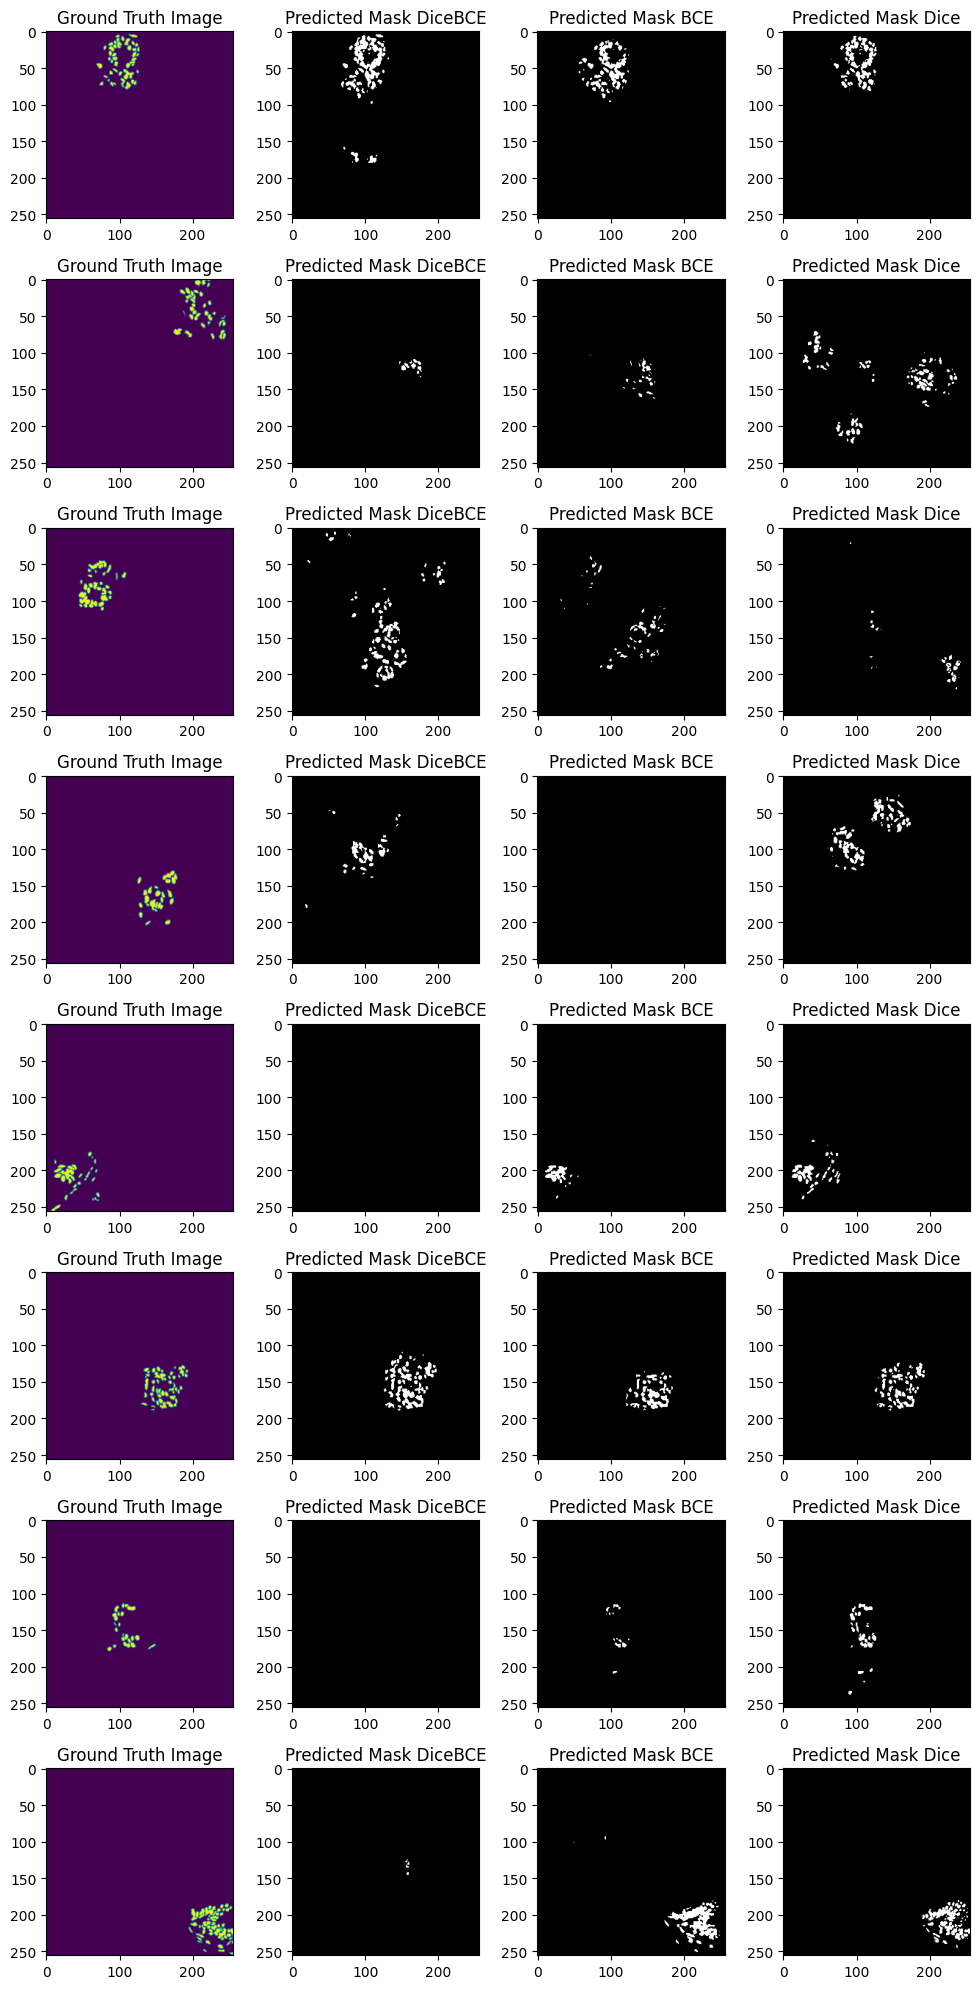

In [ ]:
def plot_result(inputs, ground_truth):

    model_dicebce = LightUNet.load_from_checkpoint("/content/model_aug_cpkt/UNet BCE+Dice/version_0/checkpoints/epoch=99-step=600.ckpt", loss='DiceBCE')
    model_bce = LightUNet.load_from_checkpoint("/content/model_aug_cpkt/UNet BCE/version_0/checkpoints/epoch=99-step=600.ckpt", loss='BCE')
    model_dice = LightUNet.load_from_checkpoint("/content/model_aug_cpkt/UNet Dice/version_1/checkpoints/epoch=99-step=600.ckpt", loss='Dice')

    inputs = inputs.to(device)

    outputs_dicebce = model_dicebce(inputs) > 0 #limit
    outputs_bce = model_bce(inputs) > 0
    outputs_dice = model_dice(inputs) > 0

    print(f"IOU DiceBce:{iou(outputs_dicebce.cpu(), ground_truth)}")
    print(f"IOU Bce:{iou(outputs_bce.cpu(), ground_truth)}")
    print(f"IOU Dice:{iou(outputs_dice.cpu(), ground_truth)}")

    print(f"IOU DiceBce mean:{iou(outputs_dicebce.cpu(), ground_truth).mean()}")
    print(f"IOU Bce mean:{iou(outputs_bce.cpu(), ground_truth).mean()}")
    print(f"IOU Dice mean:{iou(outputs_dice.cpu(), ground_truth).mean()}")

    masks_dicebce = torch.squeeze(outputs_dicebce).cpu().detach().numpy()
    masks_bce = torch.squeeze(outputs_bce).cpu().detach().numpy()
    masks_dice = torch.squeeze(outputs_dice).cpu().detach().numpy()

    fig, axes = plt.subplots(8, 4, figsize=(10, 20))
    for i in range(8):
      axes[i, 0].imshow(ground_truth[i].permute(1, 2, 0))
      axes[i, 0].set_title('Ground Truth Image')

      axes[i, 1].imshow(masks_dicebce[i], cmap='gray')
      axes[i, 1].set_title('Predicted Mask DiceBCE')

      axes[i, 2].imshow(masks_bce[i], cmap='gray')
      axes[i, 2].set_title('Predicted Mask BCE')

      axes[i, 3].imshow(masks_dice[i], cmap='gray')
      axes[i, 3].set_title('Predicted Mask Dice')

    plt.tight_layout()
    plt.show()

batch = next(iter(val_dataloader))
inputs, ground_truth = batch[0][:8], batch[1][:8]
plot_result(inputs=inputs, ground_truth=ground_truth)

На валидационной выборке лучшее качество показали Dice и BCE, протестируем их качество (а также BCEDice) на тестовом батче.

In [ ]:
batch = next(iter(test_dataloader))
inputs, ground_truth = batch[0][:8], batch[1][:8]
plot_result(inputs=inputs, ground_truth=ground_truth)

IOU DiceBce:tensor([0.2166, 0.3508, 0.4411, 0.3264, 0.2069, 0.2494, 0.1734, 0.3251])
IOU Bce:tensor([0.2500, 0.3906, 0.4121, 0.2065, 0.2536, 0.1581, 0.2540, 0.1362])
IOU Dice:tensor([0.2920, 0.3165, 0.5000, 0.4290, 0.2287, 0.3228, 0.3100, 0.3406])
IOU DiceBce mean:0.28620588779449463
IOU Bce mean:0.25762230157852173
IOU Dice mean:0.34246379137039185


UNet с функцией потерь Dice показал наилучшие результаты на метрике IoU

## Part 4: Augmentations and advanced model

Choose set of augmentations relevant for this case (at least 5 of them) using [Albumentations library](https://albumentations.ai/).
Apply them to dataset (of course dynamicaly during reading from disk).

One more thing to improve is model: use [PSPnet](https://arxiv.org/pdf/1612.01105v2) (either use library [implementation](https://smp.readthedocs.io/en/latest/models.html#pspnet) or implement yourself) as improved version of Unet.

Alternatively you may use model of your choice (it should be more advanced than Unet ofc).

Train Unet and second model on augmented data.

In [16]:
import albumentations as A

transform = A.Compose([
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.1, 0.1), rotate=(-10, 10), shear=(-5, 5)),
    A.PixelDropout(p=0.5),
    A.Transpose(p=0.5),
    A.RandomRotate90(),
    A.Perspective(p=0.5),
], is_check_shapes=False)

def collate_fn_augmentation(batch):
    images, masks = zip(*batch)

    preprocess_image = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((256, 256)),
    ])

    preprocess_mask = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((256, 256)),
    ])

    augmented_images = []
    augmented_masks = []

    for image, mask in zip(images, masks):
      transformed = transform(image=np.array(image), mask=np.array(mask))
      augmented_image = preprocess_image(transformed['image'])
      augmented_mask = preprocess_mask(transformed['mask'])

      augmented_images.append(augmented_image)
      augmented_masks.append(augmented_mask)

    images = torch.stack(augmented_images)
    masks = torch.stack(augmented_masks)

    return images, masks



train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn_augmentation, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn_augmentation, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn_augmentation, shuffle=False)

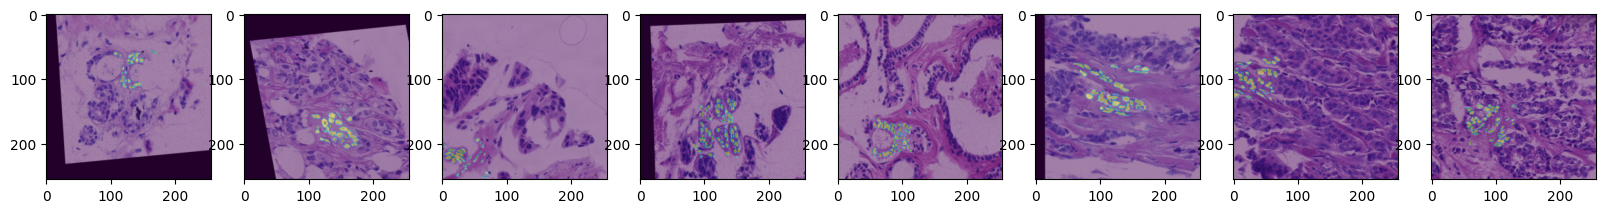

In [19]:
batch = next(iter(train_dataloader))
inputs, ground_truth = batch[0][:8], batch[1][:8]
plot_images(inputs, ground_truth)

In [20]:
model_dice = LightUNet('Dice')
logger_dice = TensorBoardLogger("model_aug_cpkt", name="UNet Dice")
trainer_dice = pl.Trainer(devices=1, accelerator=accelerator, logger=logger_dice, max_epochs=100)
trainer_dice.fit(model=model_dice, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type     | Params
-----------------------------------
0 | model | UNet     | 31.0 M
1 | loss  | DiceLoss | 0     
-----------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.174   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type     |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


IOU Dice:tensor([0.1489, 0.1140, 0.2233, 0.1671, 0.2393, 0.0497, 0.0392, 0.1089])
IOU Dice mean:0.13629475235939026


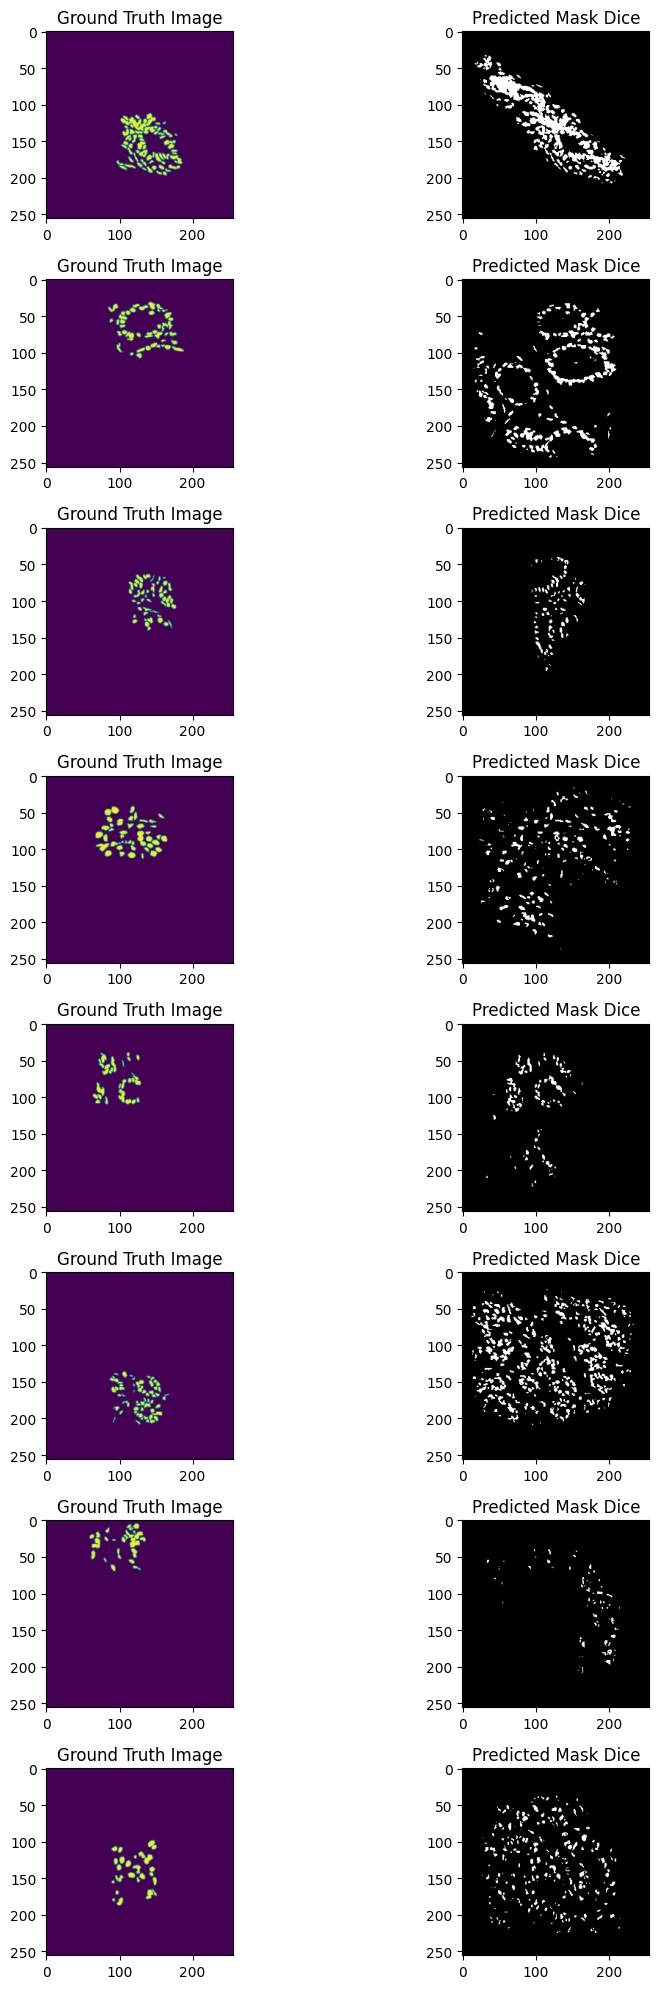

In [33]:
def plot_result(inputs, ground_truth):

    torch.use_cuda_dsa = True

    #model_dicebce = LightUNet.load_from_checkpoint("/content/model_aug_cpkt/UNet BCE+Dice/version_0/checkpoints/epoch=99-step=600.ckpt", loss='DiceBCE')
    #model_bce = LightUNet.load_from_checkpoint("/content/model_aug_cpkt/UNet BCE/version_0/checkpoints/epoch=99-step=600.ckpt", loss='BCE')
    model_dice = LightUNet.load_from_checkpoint("/content/model_aug_cpkt/UNet Dice/version_0/checkpoints/epoch=99-step=600.ckpt", loss='Dice')

    inputs = inputs.to(device)

    #outputs_dicebce = model_dicebce(inputs) > 0 #limit
    #outputs_bce = model_bce(inputs) > 0
    outputs_dice = model_dice(inputs) > 0

    #print(f"IOU DiceBce:{iou(outputs_dicebce.cpu(), ground_truth)}")
   # print(f"IOU Bce:{iou(outputs_bce.cpu(), ground_truth)}")
    print(f"IOU Dice:{iou(outputs_dice.cpu(), ground_truth)}")

    #print(f"IOU DiceBce mean:{iou(outputs_dicebce.cpu(), ground_truth).mean()}")
    #print(f"IOU Bce mean:{iou(outputs_bce.cpu(), ground_truth).mean()}")
    print(f"IOU Dice mean:{iou(outputs_dice.cpu(), ground_truth).mean()}")

    #masks_dicebce = torch.squeeze(outputs_dicebce).cpu().detach().numpy()
    #masks_bce = torch.squeeze(outputs_bce).cpu().detach().numpy()
    masks_dice = torch.squeeze(outputs_dice).cpu().detach().numpy()

    fig, axes = plt.subplots(8, 2, figsize=(10, 20))
    for i in range(8):
      axes[i, 0].imshow(ground_truth[i].permute(1, 2, 0))
      axes[i, 0].set_title('Ground Truth Image')

      #axes[i, 1].imshow(masks_dicebce[i], cmap='gray')
      #axes[i, 1].set_title('Predicted Mask DiceBCE')

      #axes[i, 2].imshow(masks_bce[i], cmap='gray')
      #axes[i, 2].set_title('Predicted Mask BCE')

      axes[i, 1].imshow(masks_dice[i], cmap='gray')
      axes[i, 1].set_title('Predicted Mask Dice')

    plt.tight_layout()
    plt.show()

batch = next(iter(val_dataloader))
inputs, ground_truth = batch[0][:8], batch[1][:8]
plot_result(inputs=inputs, ground_truth=ground_truth)

IOU Dice:tensor([0.1096, 0.0000, 0.0991, 0.0954, 0.0632, 0.1031, 0.1432, 0.1067])
IOU Dice mean:0.09003814309835434


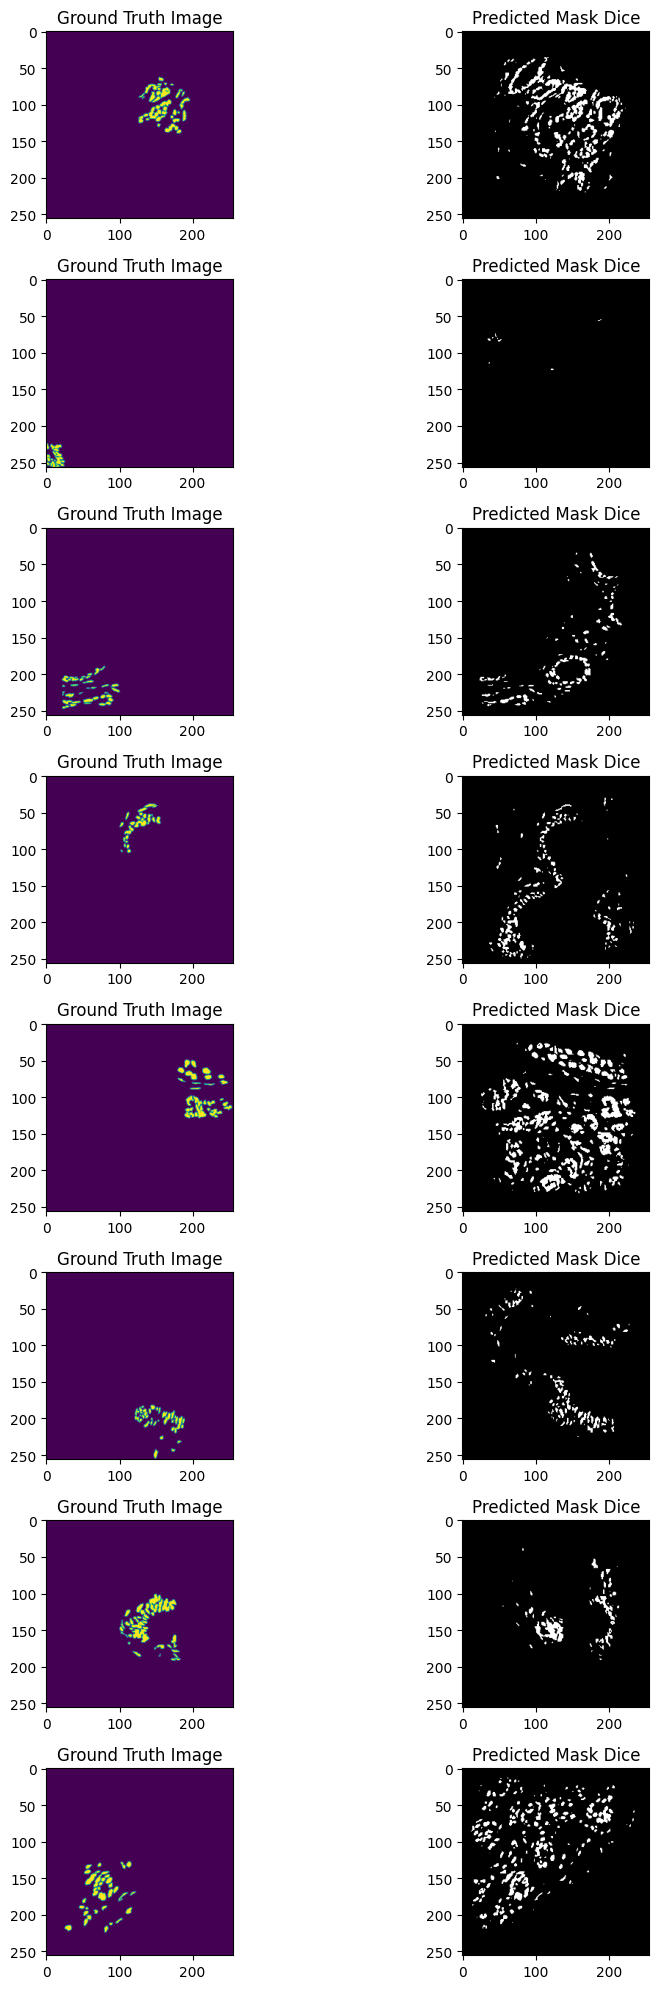

In [34]:
batch = next(iter(test_dataloader))
inputs, ground_truth = batch[0][:8], batch[1][:8]
plot_result(inputs=inputs, ground_truth=ground_truth)

Part 4.2: Augmentations and advanced model conclusion

Compare three setups:
- Unet without augmentations (with best loss)
- Unet with augmentations
- Advanced model with augmentations

_Hint: with augs and more complex model you may want to have more iterations._

Save all three trained models to disk!

Once again provide comprehensive arguments and your insights.

Wich setup is better?

Compute losses and metrics on test set. Measure improvement over first test evaluation.

Можно отметить что наилучшие результаты показала UNet с функцией потерь Dice на метрике IoU, результаты с аугментацией не оправдали ожиданий. 